In [2]:

# lgb模型
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series
import matplotlib
import matplotlib.pyplot as plt
import lightgbm as lgb
import operator
import time

# 1.读取文件
train_xy = pd.read_csv("../input/train_xy.csv",header=0,sep=",")
test_all = pd.read_csv("../input/test_all.csv",header=0,sep=",")

print(train_xy.shape)
print(test_all.shape)
# 2.合并数据
train = train_xy.copy()
test = test_all.copy()
test['y'] = -1
# 合并一下train 和 test
data = pd.concat([train,test],axis = 0) # train_xy，test_all索引上连接
print(train.shape)
print(test.shape)
print(data.shape)

# 3.对特征进行分析，分为数值型 、 类别型
numerical_features = []
categorical_features = []
for i in range(157):
    feat = "x_" + str(i+1)
    if i <= 94: # 1-95
        numerical_features.append(feat)
    else:
        categorical_features.append(feat)
print("数值型特征：",len(numerical_features))
print("类别型特征：",len(categorical_features))

# 4.统计每个样本缺失值的个数
def get_nan_count(data,feats,bins = 7):
    df = data[feats].copy()
    df = df.replace(-99,np.nan)
    df['nan_count'] = df.shape[1] - df.count(axis = 1).values  # 列数 - 非nan数
    dummy = pd.get_dummies(pd.cut(df['nan_count'],bins),prefix = 'nan') # 对缺失个数进行离散化,划分为7个区间
    print(dummy.shape)
    res = pd.concat([data,dummy],axis = 1) # 合并到原来的数据
    print(res.shape)
    return res
# 在特征行方向上面统计缺失值
data = get_nan_count(data,data.columns.values,7)

# 5.重要性top24
imp_feat = [ 'x_80', 'x_2', 'x_81', 'x_95', 'x_1',
             'x_52', 'x_63', 'x_54', 'x_43', 'x_40',
             'x_93', 'x_42', 'x_157', 'x_62', 'x_29',
             'x_61', 'x_55', 'x_79', 'x_59', 'x_69',
             'x_48', 'x_56', 'x_7', 'x_64']

print("重要的特征个数：",len(imp_feat))
# 对一些重要的特征进行填充，
for feat in imp_feat[:10]: # 填充top K ,而不是所有
    if feat in numerical_features:   # 数值型用均值
        data[feat] = data[feat].replace(-99,np.nan)
        data[feat] = data[feat].fillna(data[feat].mean()) # 均值比中位数好
    if feat in categorical_features: # 类别型：不处理
        print("这是类别特征：",feat)
        
# 6.对数值型的特征，处理为rank特征（鲁棒性好一点）
for feat in numerical_features:
    data[feat] = data[feat].rank() / float(data.shape[0]) # 排序，并且进行归一化

# 7.划分train 、test set
train = data.loc[data['y']!=-1,:] # train set
test = data.loc[data['y']==-1,:]  # test set
print(train.shape)
print(test.shape)    

# 获取特征列，去除id，group,y
no_features = ['cust_id','cust_group','y'] 
features = [feat for feat in train.columns.values if feat not in no_features]
print("所有特征的维度：",len(features))

# 8.得到输入X ，输出y
train_id = train['cust_id'].values
y = train['y'].values.astype(int)
X = train[features].values
print("X shape:",X.shape)
print("y shape:",y.shape)

test_id = test['cust_id'].values
test_data = test[features].values
print("test shape",test_data.shape)

# 9.开始训练
# 采取分层采样
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

print("start：********************************")
start = time.time()

N = 5 
skf = StratifiedKFold(n_splits=N,shuffle=True,random_state=2018)

auc_cv = []
pred_cv = []

for k,(train_in,test_in) in enumerate(skf.split(X,y)):
    X_train,X_test,y_train,y_test = X[train_in],X[test_in],\
                                    y[train_in],y[test_in]
    
    # 数据结构
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    # 设置参数
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'auc'},
        'max_depth': 4,
        'min_child_weight': 6,
        'num_leaves': 16,
        'learning_rate': 0.02,# 0.05
        'feature_fraction': 0.7,
        'bagging_fraction': 0.7,
        'bagging_freq': 5,
        #'lambda_l1':0.25,
        #'lambda_l2':0.5,
        #'scale_pos_weight':10.0/1.0, #14309.0 / 691.0, #不设置
        #'num_threads':4,
    }

    print('................Start training..........................')
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=2000,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=100,
                    verbose_eval=100)

    print('................Start predict .........................')
    # 预测
    y_pred = gbm.predict(X_test,num_iteration=gbm.best_iteration)
    # 评估
    tmp_auc = roc_auc_score(y_test,y_pred)
    auc_cv.append(tmp_auc)
    print("valid auc:",tmp_auc)
    # test
    pred = gbm.predict(test_data, num_iteration = gbm.best_iteration)
    pred_cv.append(pred) 
    
# K交叉验证的平均分数 
print('the cv information:')
print(auc_cv)
print('cv mean score',np.mean(auc_cv))

end = time.time()
print("......................run with time: ",(end - start) / 60.0 )
print("over:*********************************")

# 10.5折交叉验证结果均值融合，保存文件
mean_auc = np.mean(auc_cv)
print("mean auc:",mean_auc)
filepath = '../result/lgb_'+ str(mean_auc)+'.csv' # 线下平均分数

# 转为array
res =  np.array(pred_cv)
print("总的结果：",res.shape)
# 最后结果平均，mean
r = res.mean(axis = 0)
print('result shape:',r.shape)
result = DataFrame()
result['cust_id'] = test_id
result['pred_prob'] = r
result.to_csv(filepath,index=False,sep=",")

(15000, 160)
(10000, 159)
(15000, 160)
(10000, 160)
(25000, 160)
数值型特征： 95
类别型特征： 62
(25000, 7)
(25000, 167)
重要的特征个数： 24
(15000, 167)
(10000, 167)
所有特征的维度： 164
X shape: (15000, 164)
y shape: (15000,)
test shape (10000, 164)
start：********************************
................Start training..........................
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.804027
[200]	valid_0's auc: 0.810443
[300]	valid_0's auc: 0.816383
[400]	valid_0's auc: 0.817688
Early stopping, best iteration is:
[394]	valid_0's auc: 0.817748
................Start predict .........................
valid auc: 0.8177483170696148
................Start training..........................
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.784292
[200]	valid_0's auc: 0.792271
[300]	valid_0's auc: 0.791539
Early stopping, best iteration is:
[247]	valid_0's auc: 0.793772
................Start predict .........................
valid auc: 0.79

In [3]:
# xgb模型
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series
import time

# 1.读取文件
train_xy = pd.read_csv("../input/train_xy.csv",header=0,sep=",")
train_x = pd.read_csv("../input/train_x.csv",header=0,sep=",")
test_all = pd.read_csv("../input/test_all.csv",header=0,sep=",")

print(train_xy.shape)
print(train_x.shape)
print(test_all.shape)

# 2.合并数据
train = train_xy.copy()
test = test_all.copy()
test['y'] = -1
# 合并一下train 和 test
data = pd.concat([train,test],axis = 0) # train_xy，test_all索引上连接
print(train.shape)
print(test.shape)
print(data.shape)

# 3.对特征进行分析，分为数值型 、 类别型
numerical_features = []
categorical_features = []
for i in range(157):
    feat = "x_" + str(i+1)
    if i <= 94: # 1-95
        numerical_features.append(feat)
    else:
        categorical_features.append(feat)
print("有用的数值型特征：",len(numerical_features))
print("有用的类别型特征：",len(categorical_features))

# 4.统计每个用户缺失值的个数
def get_nan_count(data):
    df = data.copy()
    df = df.replace(-99,np.nan)
    df['nan_count'] = df.shape[1] - df.count(axis = 1).values  # 列数 - 非nan数
    dummy = pd.get_dummies(pd.cut(df['nan_count'],7),prefix = 'nan') # 对缺失个数进行离散化,划分为7个区间
    print(dummy.shape)
    res = pd.concat([data,dummy],axis = 1) # 合并到原来的数据
    print(res.shape)
    return res
data = get_nan_count(data)

# 5.重要性top24
imp_feat = [ 'x_80', 'x_2', 'x_81', 'x_95', 'x_1',
             'x_52', 'x_63', 'x_54', 'x_43', 'x_40',
             'x_93', 'x_42', 'x_157', 'x_62', 'x_29',
             'x_61', 'x_55', 'x_79', 'x_59', 'x_69',
             'x_48', 'x_56', 'x_7', 'x_64']
print("重要的特征个数：",len(imp_feat))
# 对一些重要的特征进行填充，
for feat in imp_feat[:10]: # 填充top 10 ,而不是所有
    if feat in numerical_features:   # 数值型用均值
        data[feat] = data[feat].replace(-99,np.nan)
        data[feat] = data[feat].fillna(data[feat].mean()) # 非nan均值
    if feat in categorical_features: # 类别型：不处理
        print("这是类别特征：",feat)
'''
# 6.对类别型的特征，进行one-hot 
def set_one_hot(data,categorical_feature):
    rest_feat = list(set(data.columns.values.tolist()) - set(categorical_feature))# 删除自己
    df = data[rest_feat].copy()
    dummies = [df]
    for feat in categorical_feature:
        dummy = pd.get_dummies(data[feat], prefix = feat) # 哑变量变换
        dummies.append(dummy)
    res = pd.concat(dummies,axis = 1) # 横向合并
    print("data shape:",res.shape)
    return res


# 最后的结果只对x_157进行onehot，有稍微的提升，其他的反而降分,所以感觉统一不加onehot
data = set_one_hot(data,['x_157']) 
'''
# 7.对数值型的特征，处理为rank特征（鲁棒性好一点）----其实不处理不影响，因为排序不影响大小关系，是单调的
for feat in numerical_features:
    data[feat] = data[feat].rank() / float(data.shape[0]) # 排序，并且进行归一化

# 8.划分train 、test set
train = data.loc[data['y']!=-1,:] # train set
test = data.loc[data['y']==-1,:]  # test set
print(train.shape)
print(test.shape)

# 获取特征列，去除id，group, y
no_features = ['cust_id','cust_group','y'] 
features = [feat for feat in train.columns.values if feat not in no_features]
print("所有特征的维度：",len(features))

# 9.得到输入X ，输出y
train_id = train['cust_id'].values
y = train['y'].values
X = train[features].values
print("X shape:",X.shape)
print("y shape:",y.shape)

test_id = test['cust_id'].values
test_data = test[features].values
print("test shape",test_data.shape)
# 10.xgb模型，5折交叉训练与验证
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import time

print("start：********************************")
start = time.time()

auc_list = []
pred_list = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2018)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #参数设置
    params = {'booster': 'gbtree',
              'objective':'binary:logistic',
              'eta': 0.02,
              'max_depth':4,
              'min_child_weight': 6,  
              'colsample_bytree': 0.7,
              'subsample': 0.7,
              #'gamma':0,
              #'lambda':1,
              #'alpha ':0，
              'silent':1
              }
    params['eval_metric'] = ['auc'] 
    # 数据结构
    dtrain = xgb.DMatrix(X_train, label = y_train)
    dvali = xgb.DMatrix(X_test,label = y_test)
    evallist  = [(dtrain,'train'),(dvali,'valid')]  # 'valid-auc' will be used for early stopping
    # 模型train
    model = xgb.train(params, dtrain,
                      num_boost_round=2000, 
                      evals = evallist,
                      early_stopping_rounds = 100,
                      verbose_eval=100)
    # 预测验证
    pred = model.predict(dvali, ntree_limit = model.best_ntree_limit)
    # 评估
    auc = roc_auc_score(y_test,pred)
    print('...........................auc value:',auc)
    auc_list.append(auc)
    # 预测
    dtest = xgb.DMatrix(test_data)
    pre = model.predict(dtest,ntree_limit = model.best_ntree_limit)
    pred_list.append(pre)

print('......................validate result mean :',np.mean(auc_list))

end = time.time()
print("......................run with time: ",(end - start) / 60.0)

print("over:*********************************")

# 11.5折结果均值融合，并保存文件
mean_auc = np.mean(auc_list)
print("mean auc:",mean_auc)
filepath = '../result/xgb_'+ str(mean_auc)+'.csv' # 线下平均分数
# 转为array
res =  np.array(pred_list)
print("5折结果：",res.shape)

# 最后结果，mean
r = res.mean(axis = 0)
print('result shape:',r.shape)
result = DataFrame()
result['cust_id'] = test_id
result['pred_prob'] = r
result.to_csv(filepath,index=False,sep=",")

(15000, 160)
(10000, 159)
(10000, 159)
(15000, 160)
(10000, 160)
(25000, 160)
有用的数值型特征： 95
有用的类别型特征： 62
(25000, 7)
(25000, 167)
重要的特征个数： 24
(15000, 167)
(10000, 167)
所有特征的维度： 164
X shape: (15000, 164)
y shape: (15000,)
test shape (10000, 164)
start：********************************
[0]	train-auc:0.74574	valid-auc:0.672739
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.853535	valid-auc:0.801043
[200]	train-auc:0.871309	valid-auc:0.809043
[300]	train-auc:0.888788	valid-auc:0.815921
[400]	train-auc:0.903807	valid-auc:0.816404
[500]	train-auc:0.916821	valid-auc:0.815526
Stopping. Best iteration:
[480]	train-auc:0.913855	valid-auc:0.816796

...........................auc value: 0.8167956201076875
[0]	train-auc:0.77916	valid-auc:0.725372
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.


(15000, 160)
(10000, 159)
(10000, 159)
(15000, 160)
(10000, 160)
(25000, 160)
所有特征的维度： 157
X shape: (15000, 157)
y shape: (15000,)
test shape (10000, 157)
start：********************************
......................Start train all data .......................
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.847692
[200]	training's auc: 0.86545
[300]	training's auc: 0.88024
[400]	training's auc: 0.892709
Did not meet early stopping. Best iteration is:
[450]	training's auc: 0.899285
......................run with time:  0.1330675760904948
over:*********************************


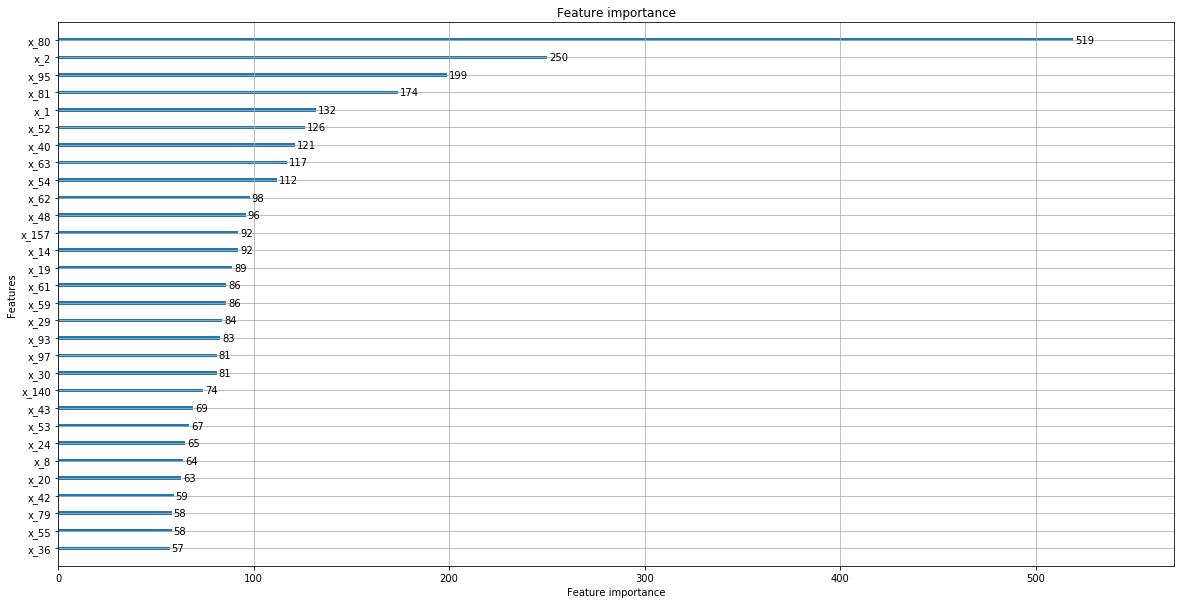

有用的特征个数: 96
有用的特征： ['x_80', 'x_2', 'x_95', 'x_81', 'x_1', 'x_52', 'x_40', 'x_63', 'x_54', 'x_62', 'x_48', 'x_14', 'x_157', 'x_19', 'x_61', 'x_59', 'x_29', 'x_93', 'x_97', 'x_30', 'x_140', 'x_43', 'x_53', 'x_24', 'x_8', 'x_20', 'x_42', 'x_55', 'x_79', 'x_36', 'x_7', 'x_35', 'x_56', 'x_47', 'x_50', 'x_57', 'x_156', 'x_38', 'x_78', 'x_68', 'x_142', 'x_64', 'x_41', 'x_72', 'x_84', 'x_44', 'x_45', 'x_46', 'x_69', 'x_58', 'x_13', 'x_141', 'x_60', 'x_99', 'x_51', 'x_82', 'x_83', 'x_154', 'x_65', 'x_67', 'x_39', 'x_91', 'x_66', 'x_153', 'x_73', 'x_88', 'x_98', 'x_96', 'x_32', 'x_49', 'x_87', 'x_101', 'x_3', 'x_90', 'x_9', 'x_155', 'x_76', 'x_100', 'x_26', 'x_77', 'x_139', 'x_4', 'x_75', 'x_22', 'x_143', 'x_27', 'x_150', 'x_16', 'x_11', 'x_144', 'x_10', 'x_86', 'x_12', 'x_74', 'x_33', 'x_5']


In [5]:
# feature importance
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series
import time
import matplotlib
import matplotlib.pyplot as plt

import operator

# 读取文件
train_xy = pd.read_csv("../input/train_xy.csv",header=0,sep=",")
train_x = pd.read_csv("../input/train_x.csv",header=0,sep=",")
test_all = pd.read_csv("../input/test_all.csv",header=0,sep=",")

print(train_xy.shape)
print(train_x.shape)
print(test_all.shape)

train = train_xy.copy()
test = test_all.copy()
test['y'] = -1
# 合并一下train 和 test
data = pd.concat([train,test],axis = 0) # train_xy，test_all索引上连接
print(train.shape)
print(test.shape)
print(data.shape)

# 获取特征列，去除id，group,y
features = [feat for feat in train.columns.values if feat not in ['cust_id','cust_group','y']]
print("所有特征的维度：",len(features))

# 得到输入X ，输出y
train_id = train['cust_id']
y = train["y"].values
X = train[features].values
print("X shape:",X.shape)
print("y shape:",y.shape)

test_id = test['cust_id']
test = test[features].values
print("test shape",test.shape)

# 开始训练
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import operator
import time

print("start：********************************")
start = time.time()

print('......................Start train all data .......................')

# 最后用全部数据train
train_all = lgb.Dataset(train[features], train['y'])
# 设置参数
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'auc'},
    'max_depth': 4,
    'min_child_weight': 6,
    'num_leaves': 16,
    'learning_rate': 0.02,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    #'lambda_l1':0.25,
     #'lambda_l2':0.5,
    #'scale_pos_weight':1,
}
model = lgb.train(params,
                train_all,
                num_boost_round=450,
                valid_sets=train_all,
                early_stopping_rounds=100,
                verbose_eval=100)

end = time.time()
print("......................run with time: ",(end - start) / 60.0 )
print("over:*********************************")
# 显示top30的特征
lgb.plot_importance(model,max_num_features = 30,figsize=(20,10))
plt.show()
# 对特征重要性排序
df = pd.DataFrame({'feature': features,'importance': model.feature_importance()}).sort_values(by='importance',ascending = False) # 降序
use = df.loc[df['importance']!=0,'feature'].tolist()
print('有用的特征个数:',len(use))
print('有用的特征：',use)